In [1]:
from scipy.io import readsav
import numpy as np

filename = 'Mars.save'
data = readsav(filename)
# Explore the contents
print(data.keys())         # Lists all top-level variables
print(data['mse_b1'])    # Access a variable (e.g., structure, array)



dict_keys(['npt', 'unixtime', 'ls_mars', 'subsolar_lng', 'subsolar_lat', 'f107_mars', 'upstream_imf', 'upstream_usw', 'upstream_nsw', 'geo_longitude', 'geo_latitude', 'altitude', 'mso_sza', 'mso_azimuthal', 'mse_azimuthal', 'mso_b0', 'mso_b1', 'mse_b0', 'mse_b1'])
[[ -1.4988122 -11.18045   -10.179465 ]
 [ -2.826375   -9.955016  -10.281759 ]
 [ -3.3528166 -10.39058    -7.932665 ]
 ...
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]]


In [ ]:
from tqdm import tqdm
import lightning.pytorch as lp

class ProgressBar_tqdm(lp.callbacks.TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(            
            disable=True,            
        )
        return bar

In [ ]:
inputs = ['geo_longitude', 
          'geo_latitude', 
          'ls_mars', 
          'subsolar_lng', 
          'subsolar_lat', 
          'mso_sza', 
          'mse_azimuthal', 
          'altitude', 
          'upstream_imf', 
          'upstream_usw',
          'upstream_nsw',
          'f107_mars'
          ]
target = 'mse_b1'

checkpoint_dir = 'Checkpoints/'


In [ ]:
features = []

for key in inputs:
    if key not in data:
        raise KeyError(f"Missing key in data: {key}")
    
    arr = np.asarray(data[key])
    
    if arr.ndim == 1:
        features.append(arr.reshape(-1, 1))  # Convert to [N, 1]
    elif arr.ndim == 2:
        features.append(arr)  # e.g., [N, 3]
    else:
        raise ValueError(f"Unsupported shape for {key}: {arr.shape}")

# Concatenate into feature matrix X
X = np.hstack(features)
Y = np.asarray(np.sum(data[target]**2, axis=1))
print(f"Final shape of X: {X.shape}")  # Should be [N, num_total_features]
print(f"Final shape of Y: {Y.shape}")  # Should be [N, num_total_features]

# Create a mask for rows without NaNs in X and Y
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(Y)

# Apply the mask to filter both X and Y
X_clean = X[mask]
Y_clean = Y[mask]

print(f"Clean X shape: {X_clean.shape}")
print(f"Clean Y shape: {Y_clean.shape}")

Final shape of X: (28527661, 16)
Final shape of Y: (28527661,)
Clean X shape: (28471155, 16)
Clean Y shape: (28471155,)


In [ ]:
import torch
import torch.nn as nn
from lightning.pytorch import LightningModule
from torch.utils.data import DataLoader, TensorDataset, random_split

class MLPRegressor(LightningModule):
    def __init__(self, input_dim=16, hidden_dims=[64, 32], lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))  # Output layer

        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x).squeeze(-1)  # Output shape: [batch_size]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("valid_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)


In [ ]:
from sklearn.model_selection import train_test_split

# Convert to torch tensors
X_tensor = torch.tensor(X_clean, dtype=torch.float32)
Y_tensor = torch.tensor(Y_clean, dtype=torch.float32)

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X_tensor, 
                                                  Y_tensor, 
                                                  test_size=0.2, 
                                                  random_state=42)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, 
                          batch_size=1024, 
                          num_workers=12,
                          shuffle=True)
val_loader = DataLoader(val_dataset, 
                        batch_size=1024,
                        num_workers=12)


In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar

model = MLPRegressor(input_dim=X.shape[1], hidden_dims=[128, 64], lr=1e-3)

bar = TQDMProgressBar()
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='test',
    save_top_k=1,
    verbose=True,
    monitor="valid_loss",
    # monitor="train_loss",
    mode="min")
# bar = LitProgressBar()
early_stopping_callback = EarlyStopping('valid_loss',
                                        patience=10)
trainer = Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    logger=True,
    deterministic=True,
    num_sanity_val_steps=1,        
    log_every_n_steps=5,
    gradient_clip_val=1.0,
    callbacks=[bar,
                checkpoint_callback, 
                early_stopping_callback,
            #    accumulator
                ],
    precision=32
)

trainer.fit(model, train_loader, val_loader)


Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 10.5 K | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7b9129220fe0>
Traceback (most recent call last):
  File "/home/anhu9360/anaconda3/envs/pytorch_light/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 1943099, 1943167, 1943230) exited unexpectedly

In [4]:
import h5py
import numpy as np
from scipy.io import readsav

from funs import plot_prediction_sza_alt 
from funs import plot_binned_prediction_contour
from funs import plot_dual_binned_prediction_contour

save_h5 = 'Res/results.h5'
figname = 'Figs/sza_vs_alt.png'

# N = 9234250

with h5py.File(save_h5, 'r') as f:
    
    pred = np.array(f['Y_pred'])
    Y = np.array(f['Y'])
    X = np.array(f['X'])

filename = 'Mars.save'
data = readsav(filename)

############## denormalize & retrieve ####################
alt_mean = data['altitude'].flatten().mean()
alt_std = data['altitude'].flatten().std()
altitude = X[:, 11] * alt_std + alt_mean
sza = np.rad2deg(np.arccos(X[:, 10].flatten()))

print('the shape of sza: {}'.format(sza.shape))
print('the shape of altitude: {}'.format(altitude.shape))
print('the shape of pred: {}'.format(pred.shape))
print('the shape of Y: {}'.format(Y.shape))




the shape of sza: (28471155,)
the shape of altitude: (28471155,)
the shape of pred: (28471155,)
the shape of Y: (28471155,)


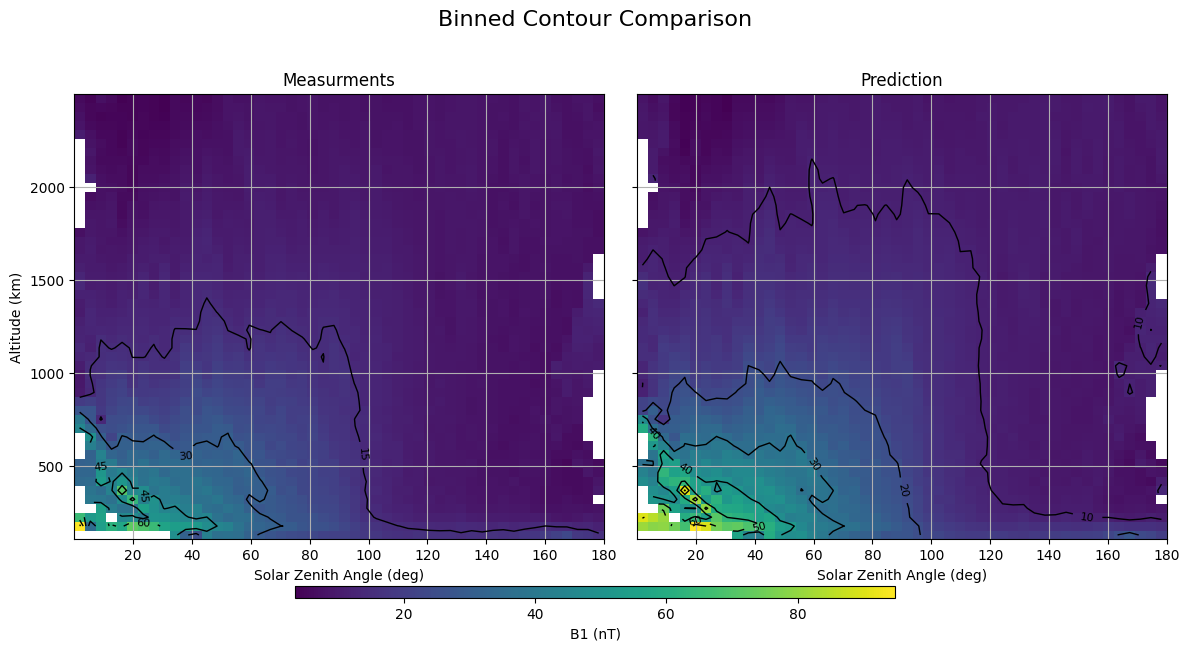

In [ ]:
from funs import plot_dual_binned_prediction_contour

idx = np.where(altitude<2500)[0]

plot_dual_binned_prediction_contour(
    sza = sza, 
    altitude = altitude, 
    predict = pred,
    measure = Y,
    idx_sel=idx,
    bins=50,
    figname = 'Figs/B1_sza_vs_alt.png',
    )

plot_dual_binned_prediction_contour(
    sza = sza, 
    altitude = altitude, 
    predict = pred,
    measure = Y,
    bins=50,
    figname = figname,
    )

In [ ]:
from funs import plot_lat_lon_B1_dualpanel
plot_lat_lon_B1_dualpanel(
    lat=df['geo_latitude'].values,
    lon=df['geo_longitude'].values,
    alt=df['altitude'].values,
    B1_true=B1_gt,
    B1_pred=B1_model,
    target_alt=400,
    alt_tol=10,
    bins=120
)